# UpscaleModel training
Below, we train the decoder (UpscaleModel), which takes the activations of the selected ResNet50 layer as input and attempts to reconstruct the image, which produced them.


Note that the results in this notebook are not of the longest / best training. The best results in the report required 500 batches, although we tried as much as 2000.

In [71]:
%load_ext autoreload
%autoreload 2

import os
import torch

from os.path import join
from csng.imagenet.models import ResnetExtractor, UpsampleModel, count_parameters
from tqdm import tqdm
from random import random
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torchvision

from matplotlib import pyplot as plt
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Hyperparametrs

In [72]:
# Define the hyperparameters and other constants
BATCH_SIZE = 64
BATCHES_PER_VALIDATION = 10 # How many batches to train on before evaluating the model on the validation set

TRAIN_SIZE = 100 * BATCH_SIZE
VALIDATION_SIZE = 2 * BATCH_SIZE

EPOCHS = 1
WEIGHT_DECAY=5e-3
LEARNING_RATE = .00005

device = os.environ["DEVICE"]

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224

## Dataset

In [73]:
# Create the dataset and data loaders

class CachedImageNet(ImageNet):
    """
    ImageNet dataset with caching for the features extracted from the ResNet model.
    """
    def __init__(self, root, split, version='0.1'):
        TRANSFORM = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        super().__init__(root=root, split=split, transform=TRANSFORM)
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet_extractor = None

    def get_extractor(self):
        if self.resnet_extractor is None:
            self.resnet_extractor = ResnetExtractor()
        return self.resnet_extractor

    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        img, _ = super().__getitem__(index)

        cache_path = self._get_cache_path(index)
        features = None
        if not os.path.exists(cache_path):
            IMGNET_NORM = transforms.Compose([
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            imagenet_input = torchvision.transforms.functional.rgb_to_grayscale(IMGNET_NORM(img), num_output_channels=3).to(device).unsqueeze(0)
            features = self.get_extractor().get_features(imagenet_input)
            self.save_atomic(features, cache_path)
        else:
            features = torch.load(cache_path).to(device)

        target = F.rgb_to_grayscale(img, num_output_channels=1)
        return features, target
    def save_atomic(self, value, name):
        tmp_name = name + '.tmp' + str(random())
        torch.save(value, tmp_name)
        os.replace(tmp_name, name)

mp.set_start_method('spawn', force=True)

train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split='train',
    version='1.1'
)
assert(len(train_dataset) >= TRAIN_SIZE + VALIDATION_SIZE)

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
validation_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + VALIDATION_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
validation_subset = Subset(train_dataset, validation_subset_indices)


# Create DataLoaders for training and validation
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

validation_loader = DataLoader(
    dataset=validation_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle validation data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Validation loader contains {len(validation_loader)} batches.")


Train loader contains 100 batches.
Validation loader contains 2 batches.


torch.Size([64, 1, 224, 224])


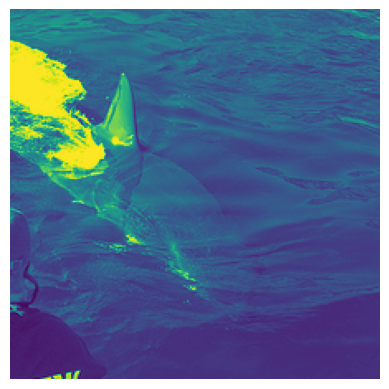

In [74]:
# Visualize a data sample
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)
features, targets = next(data_iter)
print(targets.shape)
show_image(targets[0])

## Creating and training the model

In [75]:

model = UpsampleModel()

# Test the model with dummy data.
input_tensor = torch.randn(1, 1024, 14, 14)
output_tensor = model(input_tensor)
assert output_tensor.shape == torch.Size([1,1,224,224])

# Calculate the number of trainable parameters of the model.
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params = count_parameters(model)
print("Total parametrs: ", params)
print("Params in samples : ", params / (224*224))

Total parametrs:  24511329
Params in samples :  488.5070352359694


In [76]:
# Create criterion, optimizer, etc.

criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
T_max = len(train_loader) * EPOCHS  # Total number of batches across all epochs
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

In [77]:
# Training loop
model.to(device)

training_losses = []
validation_losses = []
validation_batches = []

losses = []
for epoch in range(EPOCHS):
    for i, (features, target) in tqdm(enumerate(train_loader)):
        model.train()
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the scheduler after each batch
        scheduler.step()

        # Log the running loss
        training_losses.append(loss.item())

        if (len(train_loader) - i) % BATCHES_PER_VALIDATION == 0: # Validation
            model.eval()
            with torch.no_grad():
                val_loss = 0
                for val_features, val_target in validation_loader:
                    val_features = val_features.to(device)
                    val_target = val_target.to(device)
                    val_output = model(val_features)
                    val_loss += criterion(val_output, val_target).item()
                validation_losses.append(val_loss / len(validation_loader))
                validation_batches.append(i)
            print(f"Epoch {epoch+1}, Batch {i+1}, LR: {scheduler.get_last_lr()[0]:.6f}, Loss: {validation_losses[-1]:.4f}")


1it [00:03,  3.43s/it]

Epoch 1, Batch 1, LR: 0.000050, Loss: 0.7634


11it [00:26,  2.57s/it]

Epoch 1, Batch 11, LR: 0.000049, Loss: 0.7762


21it [00:48,  2.55s/it]

Epoch 1, Batch 21, LR: 0.000045, Loss: 0.7263


31it [01:11,  2.54s/it]

Epoch 1, Batch 31, LR: 0.000039, Loss: 0.7131


41it [01:33,  2.56s/it]

Epoch 1, Batch 41, LR: 0.000032, Loss: 0.6283


51it [01:56,  2.57s/it]

Epoch 1, Batch 51, LR: 0.000024, Loss: 0.5952


61it [02:18,  2.55s/it]

Epoch 1, Batch 61, LR: 0.000017, Loss: 0.5885


71it [02:41,  2.55s/it]

Epoch 1, Batch 71, LR: 0.000010, Loss: 0.5864


81it [03:04,  2.55s/it]

Epoch 1, Batch 81, LR: 0.000004, Loss: 0.5852


91it [03:27,  2.58s/it]

Epoch 1, Batch 91, LR: 0.000001, Loss: 0.5848


100it [03:45,  2.26s/it]


Text(0, 0.5, 'BCE Loss')

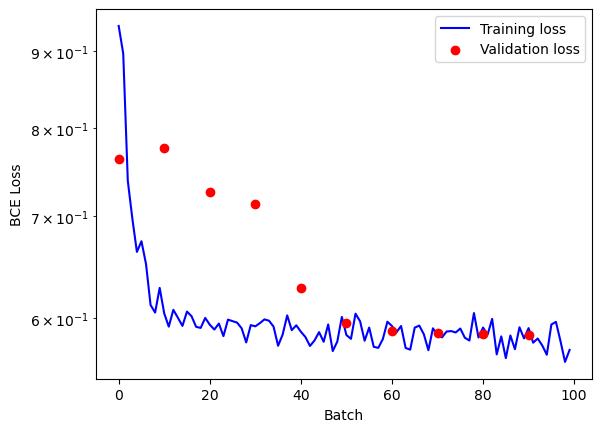

In [78]:
# Plot training loss
plt.plot(training_losses, label='Training loss', color='blue', zorder=1)

plt.scatter(validation_batches, validation_losses, label='Validation loss', color='red', zorder=2)
plt.legend()
plt.yscale('log')

plt.xlabel('Batch')
plt.ylabel('BCE Loss')

# Visualizing performance on the validation set

100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.44it/s]


Validation loss: 0.5847


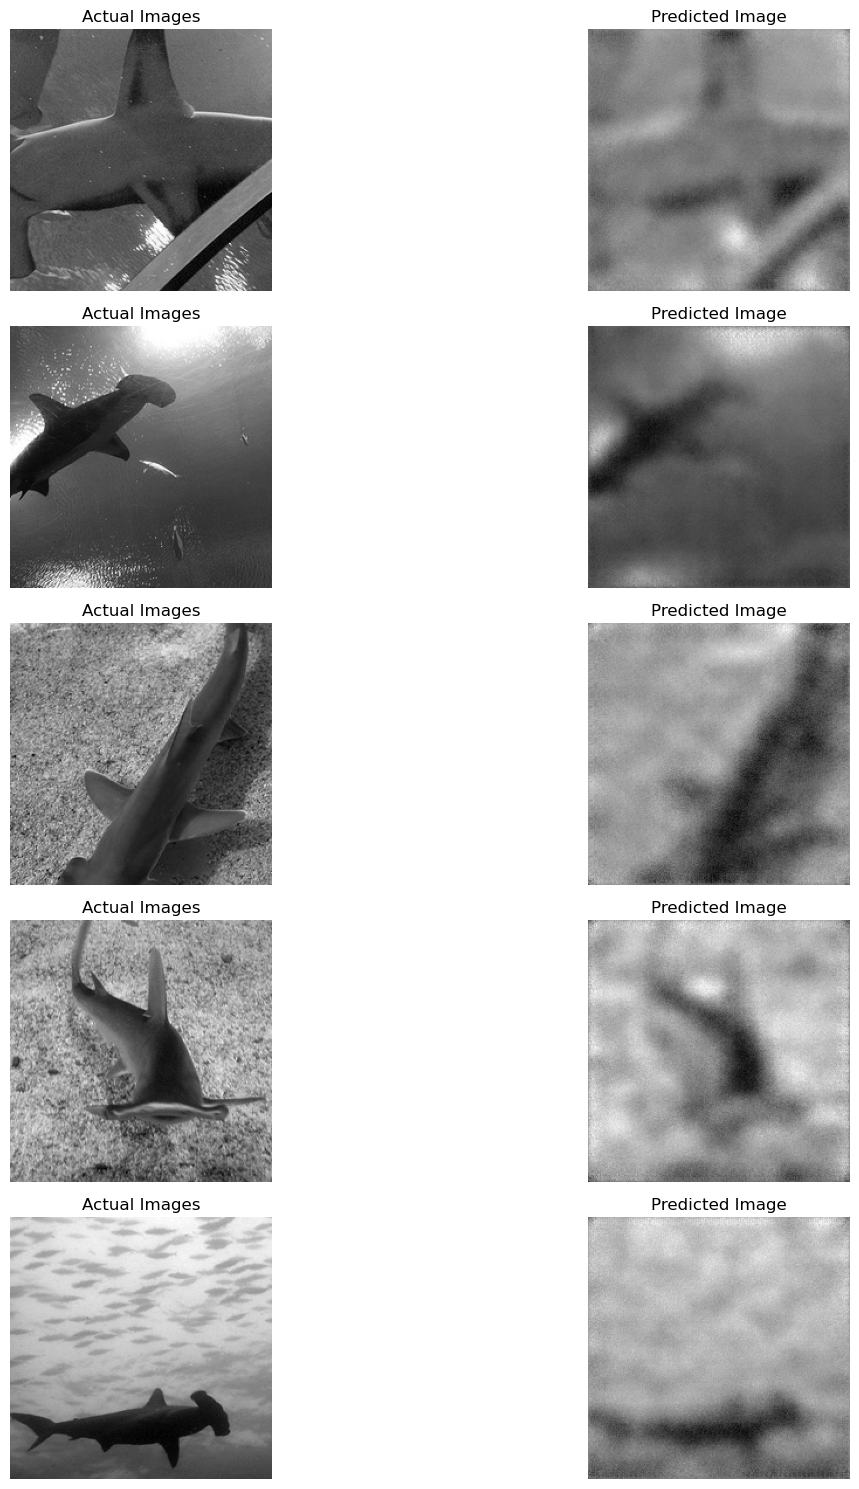

-3.3780236


In [79]:

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions


def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Images")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Image")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


validation_loss, targets, predictions = evaluate_partial_model(model, validation_loader, device)
print(f"Validation loss: {validation_loss:.4f}")

num_examples = 5  # Number of examples to visualize
plot_examples(targets[:num_examples].cpu().numpy(), predictions[:num_examples].cpu().numpy())
print(min(predictions[0].cpu().numpy().flatten()))

In [80]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
name = join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt")
torch.save(model, name)
print("Model saved to ", name)

Model saved to  /scratch/izar/vanousek/cs-433-project/models/mlp2499452.pt


# Test Loss
The loss on test dataset was only evaluated after the hyperparameters were tuned on the validation set. While we don't make claims about the generalization of the second component on its own, its good to include test loss as a sanity check.

In [81]:

test_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split='val', # We use the images from the imagenet validation set for the test set
    version='1.1'
)

test_subset_indices = list(range(BATCH_SIZE * 100))  # Indices for the training subset

# Create the subsets
test_subset = Subset(test_dataset, train_subset_indices)

test_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

validation_loss, targets, predictions = evaluate_partial_model(model, validation_loader, device)
print(f"Validation Loss: {validation_loss:.4f}")

100%|█████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.50it/s]

Validation Loss: 0.5847
